In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, mcoe, analysis, constants, settings

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
# What is this chained_assignment thing all about?
pd.options.mode.chained_assignment = None
%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

In [3]:
pudl_engine  = pudl.db_connect_pudl()

## Pull and Prepare Data

In [44]:
g9_summed = mcoe.generation_pull_eia923(pudl_engine)
g8, g8_es = mcoe.generators_pull_eia860(pudl_engine)
frc9_summed, frc9_summed_plant = mcoe.fuel_reciepts_costs_pull_eia923(pudl_engine)
bga8 = mcoe.boiler_generator_pull_eia860(pudl_engine)
bf9_summed, bf9_plant_summed = mcoe.boiler_fuel_pull_eia923(pudl_engine)

## Do the Heat Rate Calculations

In [14]:
plant_id = 'plant_id_eia'
min_heat_rate = 5.5

# Just for reference...
hr_old = mcoe.heat_rate(bga8, g9_summed, bf9_summed,
                        bf9_plant_summed, pudl_engine,
                        id_col='plant_id_eia', min_heat_rate=-1000)

# Calculate heat rates for unassociated plants:
hru = mcoe.heat_rate_unassn(bga8, g9_summed, bf9_summed,
                            bf9_plant_summed, pudl_engine,
                            plant_id='plant_id_eia')

# Calculate heat rates for associated plants:
hra = mcoe.heat_rate_assn(bga8, g9_summed, bf9_summed,
                          bf9_plant_summed, pudl_engine,
                          plant_id='plant_id_eia')

# Dissociate all the plants, and calculate heat rates at
# the plant level:
hrd = mcoe.heat_rate_unassn(bga8, g9_summed, bf9_summed,
                            bf9_plant_summed, pudl_engine,
                            plant_id='plant_id_eia', dissociate=True)

# Identify which plants (either associated or unassociated) are
# apparently "contaminated" by virtue of having obviously wrong
# heat rates. This means their boiler/generator mappings or data
# have something wonky going on:
bad_plants_assoc = hra[hra.heat_rate_mmbtu_mwh < min_heat_rate][plant_id].unique()
bad_plants_unassoc = hru[hru.heat_rate_mmbtu_mwh < min_heat_rate][plant_id].unique()
bad_plants = np.append(bad_plants_assoc, bad_plants_unassoc)

# Use that master list of "bad plants" to sort both the associated
# and unassociated plants into usable and unusable data:
hra_bad = hra[hra[plant_id].isin(bad_plants)]
hra_good = hra[~hra[plant_id].isin(bad_plants)]
hru_bad = hru[hru[plant_id].isin(bad_plants)]
hru_good = hru[~hru[plant_id].isin(bad_plants)]

one_fuel_plants = g8_es[g8_es['energy_source_count'] == 1][plant_id]

# There are several reasons that a plant might have ended up
# in the "bad" plants -- i.e. those with any generator level
# heat rates below the minimum plausible heat rate value.
# Sometimes this is because there's truly missing data, like
# fuel that was delivered and burned, but which doesn't show up
# in the boiler fuel table -- there's no getting around that.
# Other times, it's because the boiler/generator mapping was
# messed up somehow. By looking at the plant level average heat
# rates, we can still get some useful information out of the plant
# if all of the fuel & generation were reported.
hrd_leftover = hrd[(hrd[plant_id].isin(bad_plants))]

# If there's more than one fuel... then we can't effectively screen
# based on heat rate -- zero + high can average out to "reasonable"
bad_hrd_mask = ((~hrd_leftover[plant_id].isin(one_fuel_plants)) |
                (hrd_leftover.heat_rate_mmbtu_mwh < min_heat_rate))
hrd_bad = hrd_leftover[bad_hrd_mask]
hrd_fix = hrd_leftover[~bad_hrd_mask]

# Tag the records so we know what kind they are
hra_good['heatrate_calc'] = 'associated_good'
hru_good['heatrate_calc'] = 'unassociated_good'
hrd_fix['heatrate_calc'] = 'dissociated_fix'

# Compile the usable heatrates into one dataframe
hr_good = pd.concat([hra_good, hru_good, hrd_fix])

In [29]:
def hr_hist(hr_dfs, labels, bins=200, range=(0,20), weighted=True,
            title="Heat Rates", save=False, outfile='heatrate.png', alpha=1.0):
    for hr_df, label in zip(hr_dfs, labels):
        df = hr_df[['heat_rate_mmbtu_mwh','net_generation_mwh']].dropna()
        if weighted:
            weights = df.net_generation_mwh
            ylabel = 'MWh generated'
        else:
            weights=None
            ylabel = 'generator-years'
        plt.hist(df.heat_rate_mmbtu_mwh, weights=weights,
                 bins=bins, range=range, label=label, alpha=alpha)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Heat Rate (mmBTU/MWh)')
    plt.legend()
    if save:
        plt.savefig(outfile)
    plt.show()

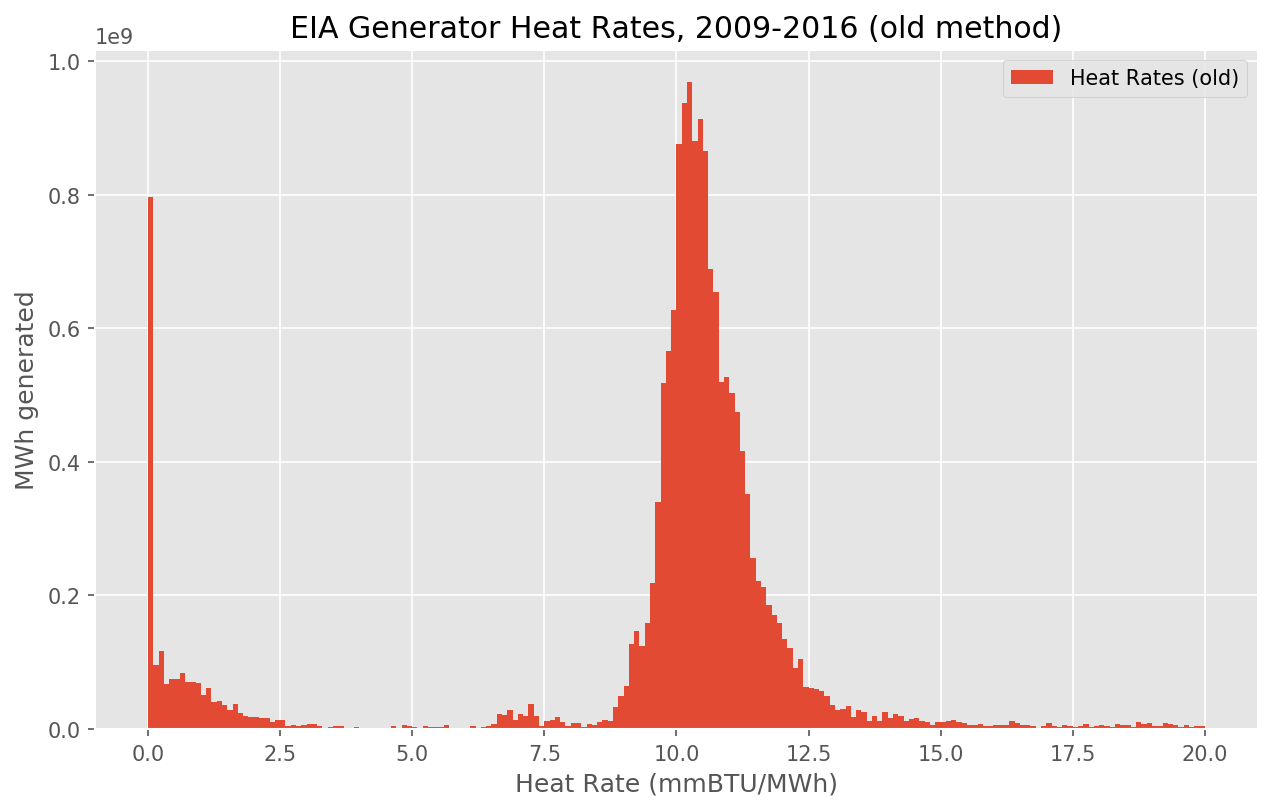

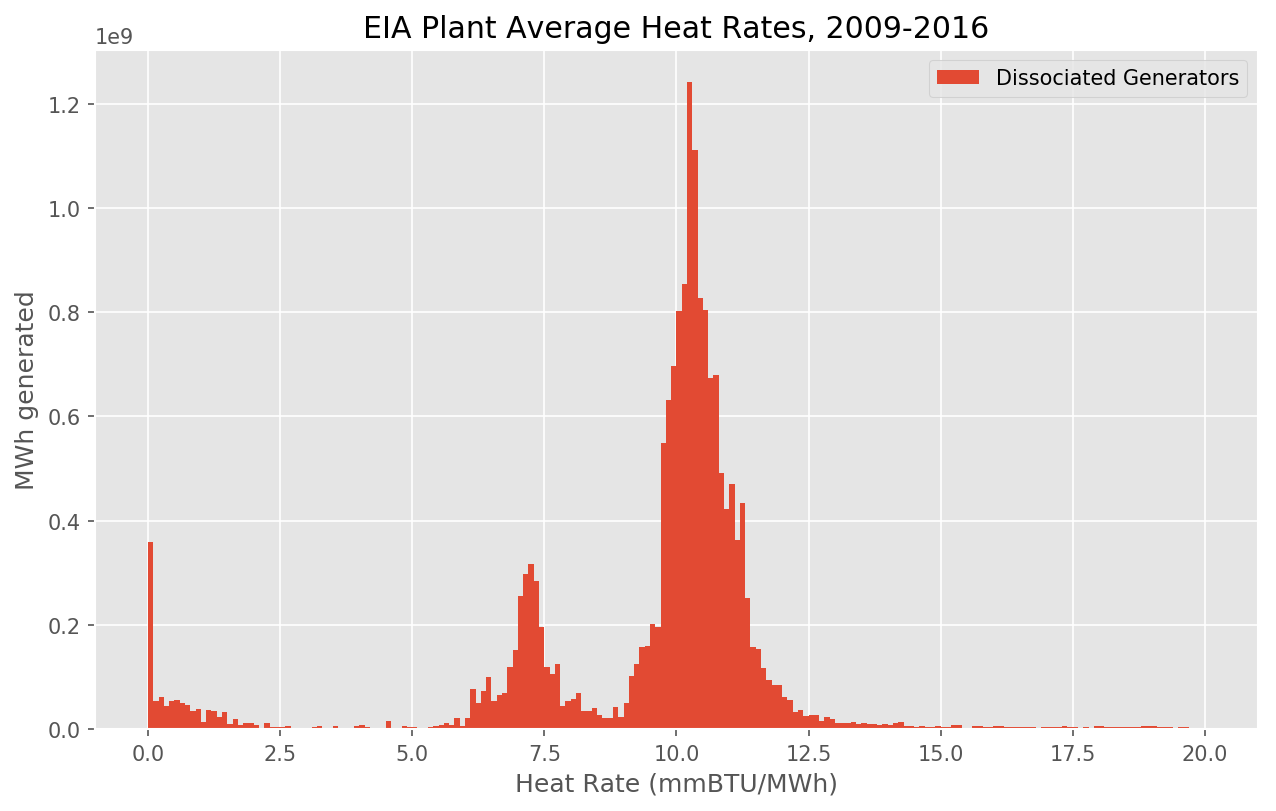

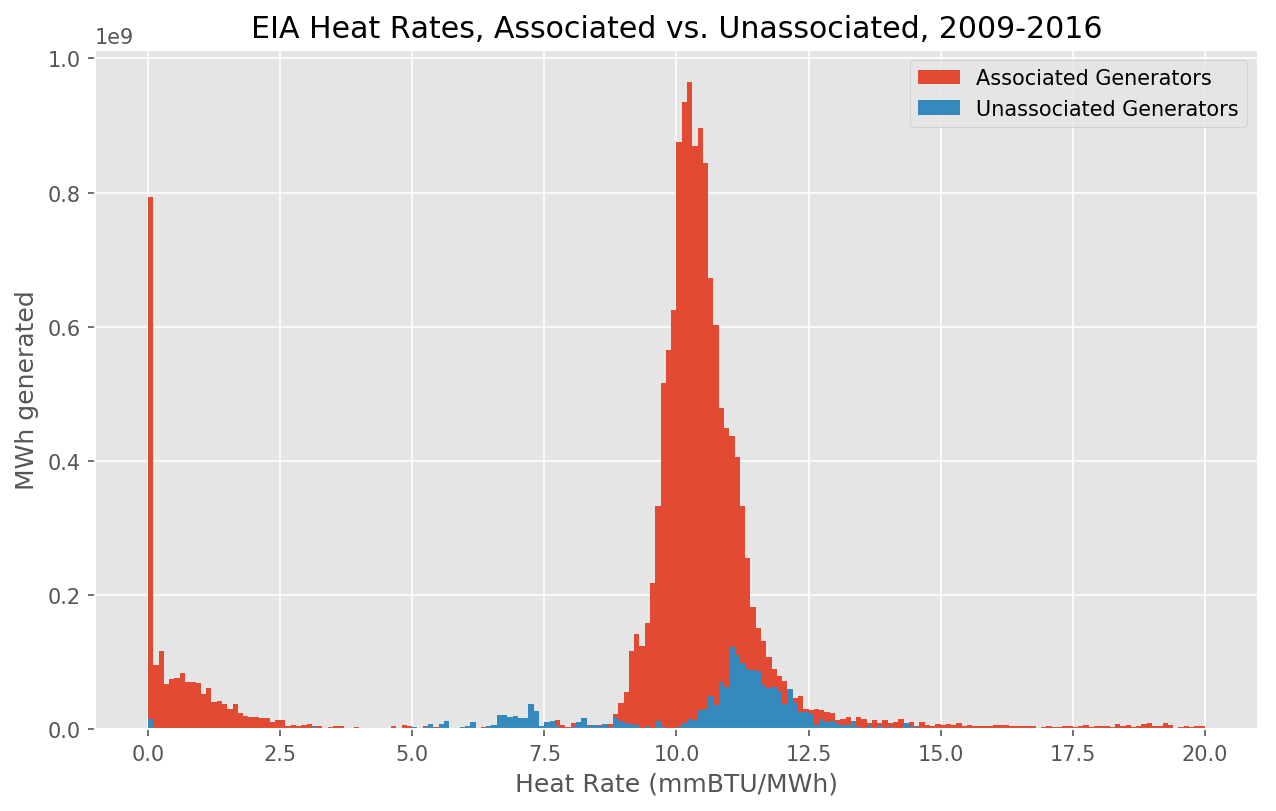

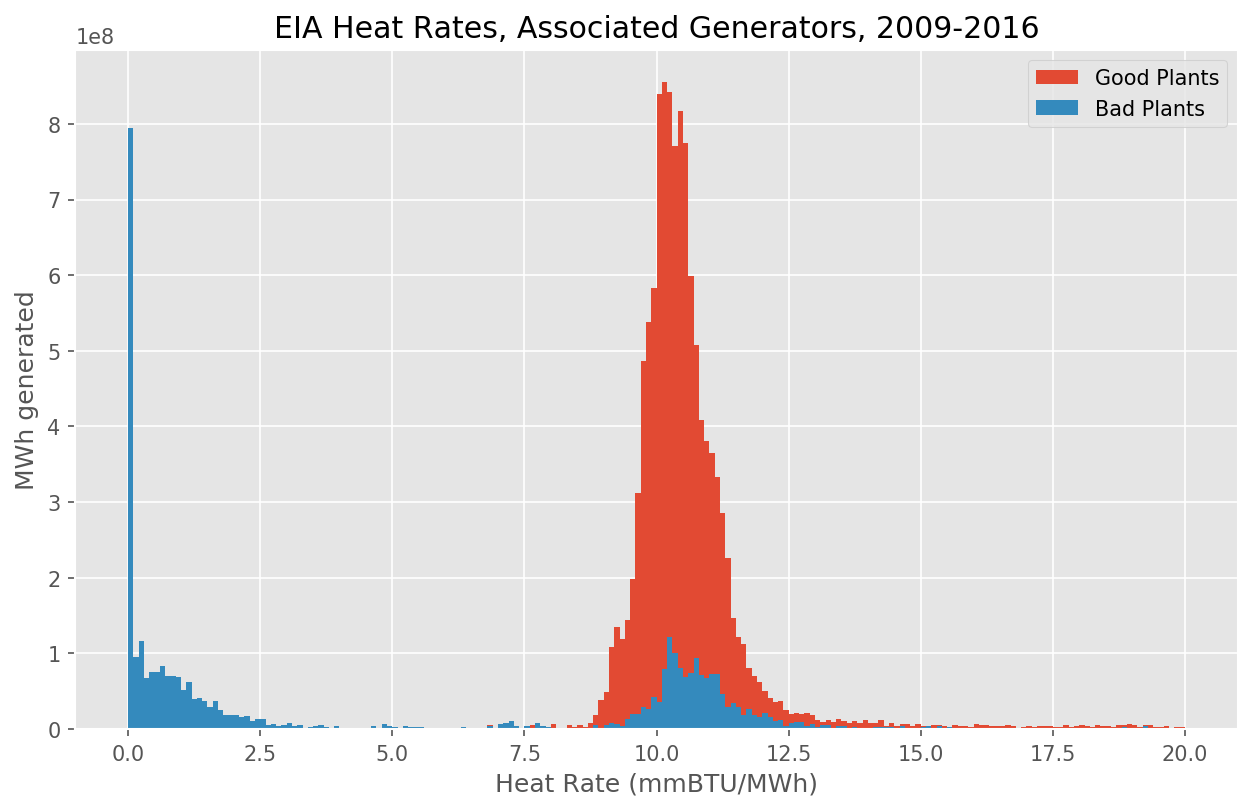

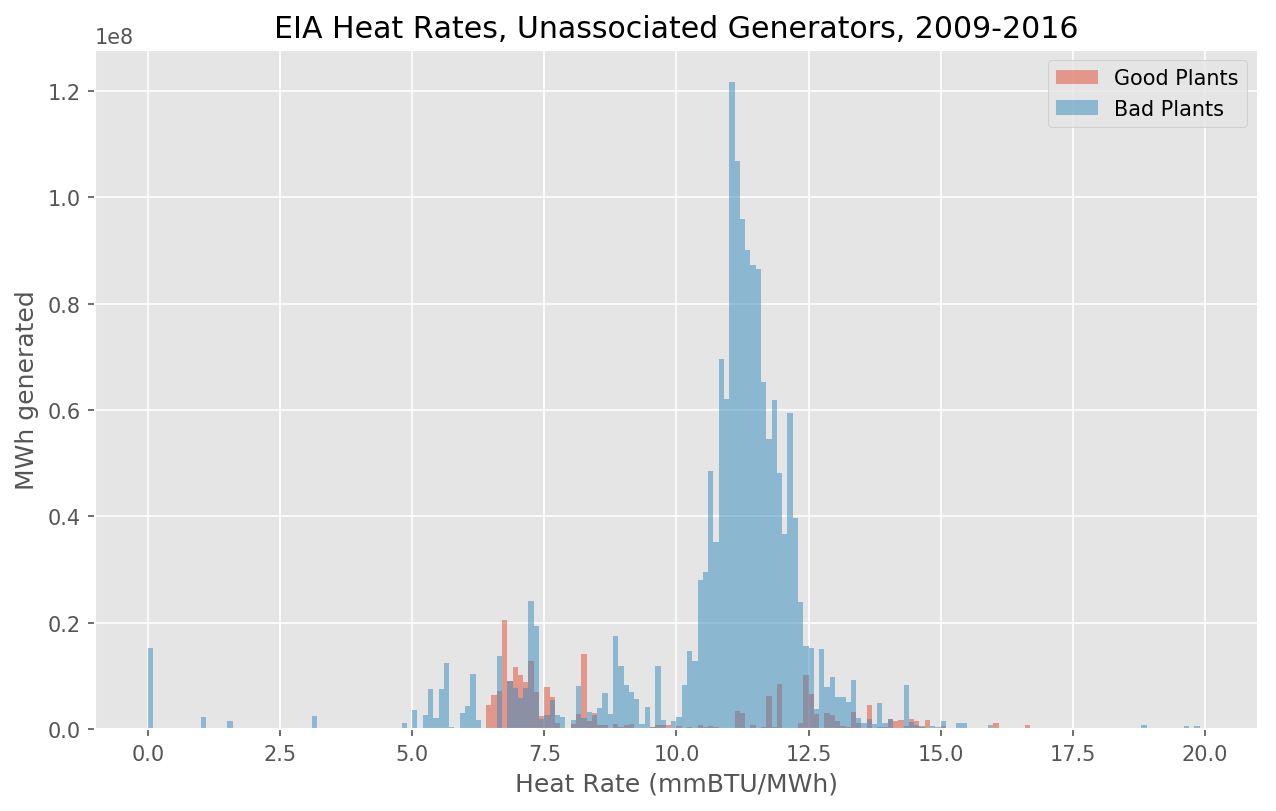

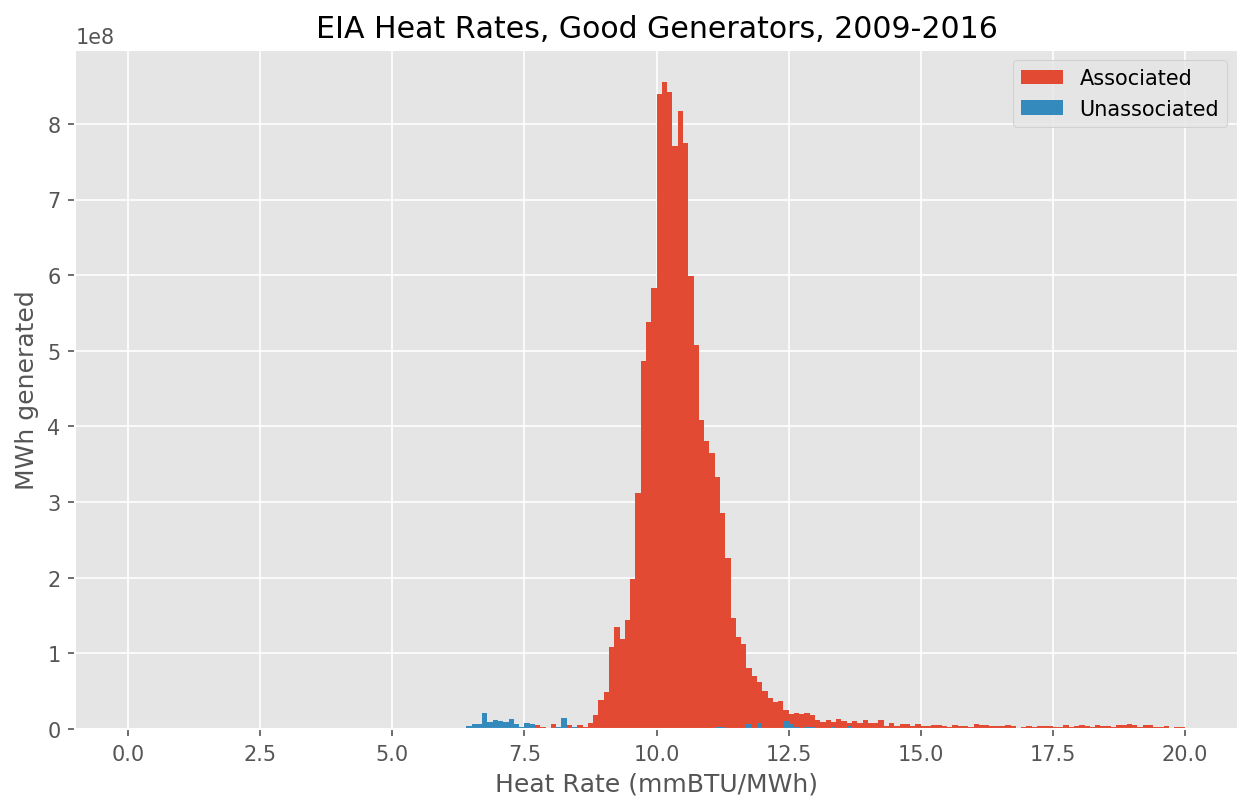

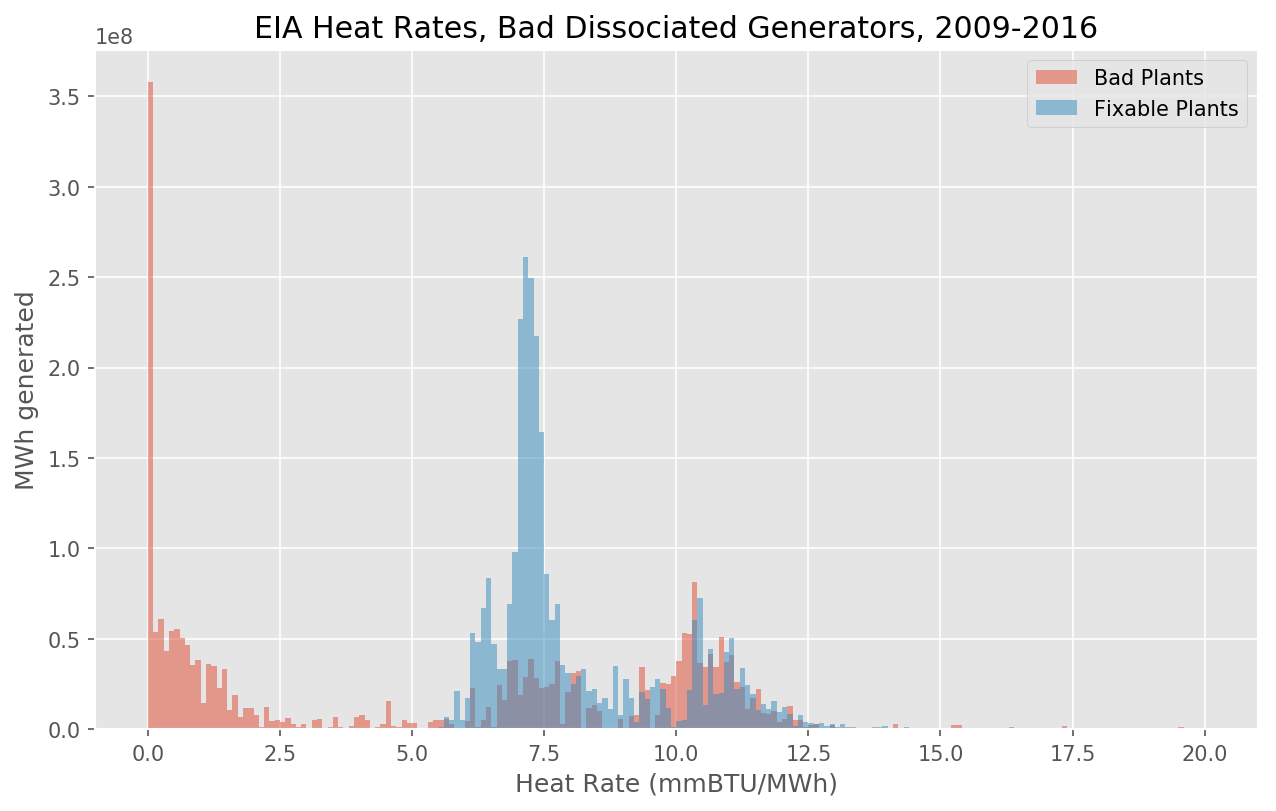

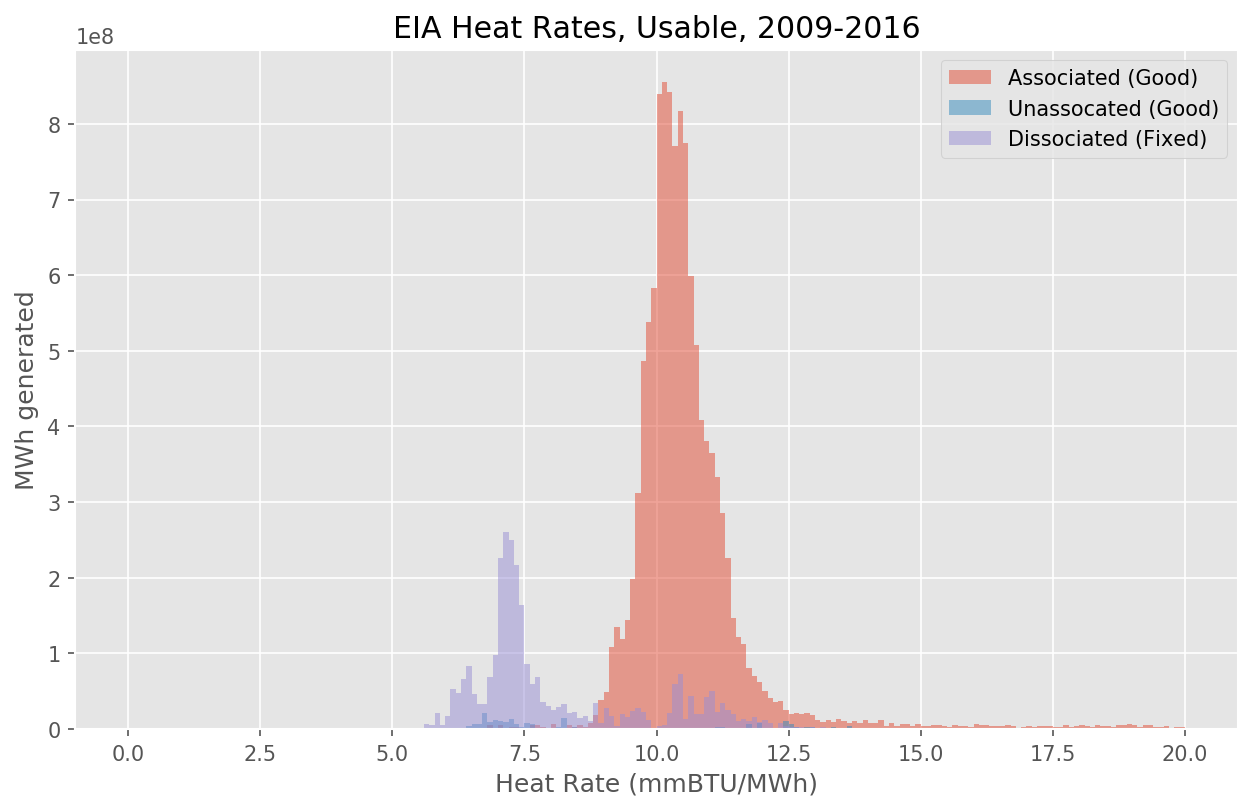

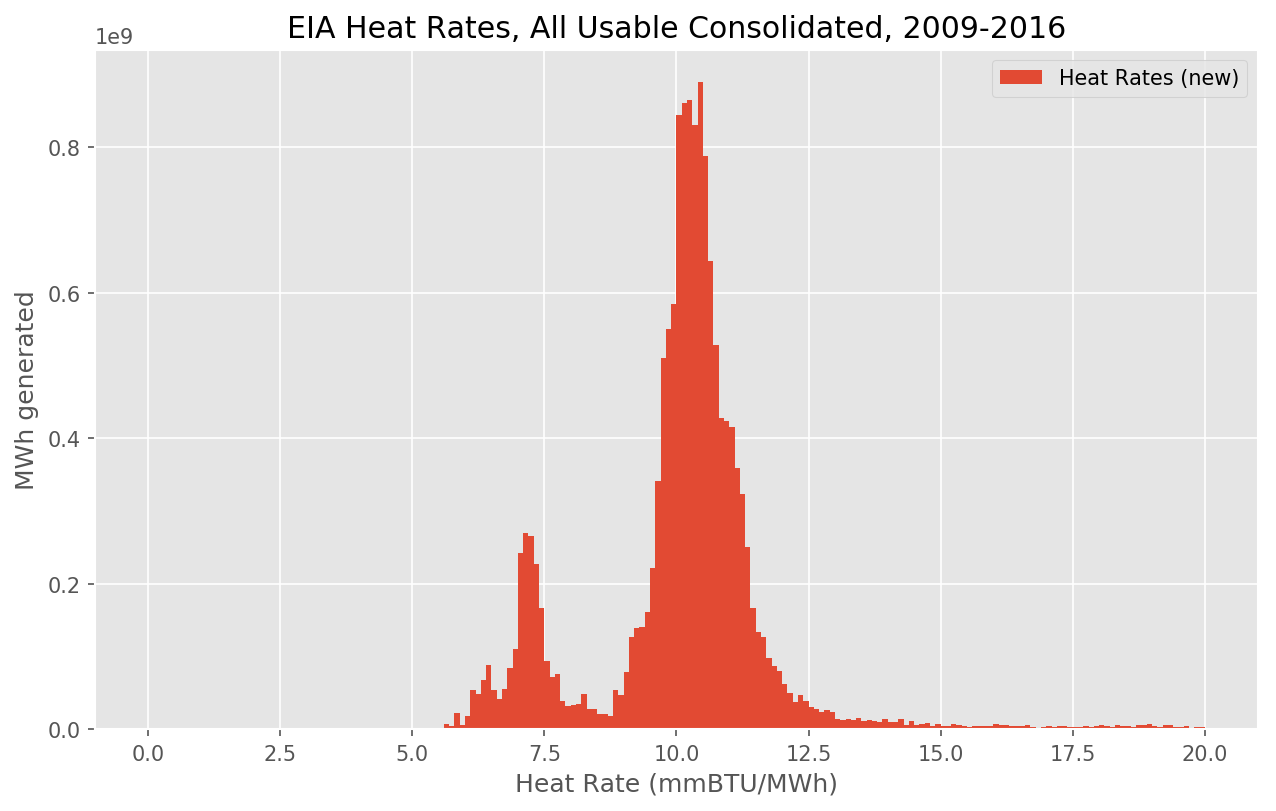

In [40]:
hr_save=False
hist_range = (0,20)
nbins = 200

hr_hist([hr_old,], labels=['Heat Rates (old)'],
        title='EIA Generator Heat Rates, 2009-2016 (old method)',
        range=hist_range, bins=nbins,
        save=hr_save, outfile='01-Heat Rates (OLD).png')

hr_hist([hrd,], labels=['Dissociated Generators'],
        title='EIA Plant Average Heat Rates, 2009-2016',
        range=hist_range, bins=nbins,
        save=hr_save, outfile='02-Heat Rates (Dissociated).png')

hr_hist([hra, hru], labels=['Associated Generators', 'Unassociated Generators'],
        title='EIA Heat Rates, Associated vs. Unassociated, 2009-2016',
        range=hist_range, bins=nbins,
        save=hr_save, outfile='03-Heat Rates (Associated + Unassociated).png')

hr_hist([hra_good, hra_bad], labels=['Good Plants', 'Bad Plants'],
        title='EIA Heat Rates, Associated Generators, 2009-2016',
        range=hist_range, bins=nbins,
        save=hr_save, outfile='04-Heat Rates (Associated Good + Bad).png')

hr_hist([hru_good, hru_bad], labels=['Good Plants', 'Bad Plants'],
        title='EIA Heat Rates, Unassociated Generators, 2009-2016',
        range=hist_range, bins=nbins, alpha=0.5,
        save=hr_save, outfile='05-Heat Rates (Unassociated Good + Bad).png')

hr_hist([hra_good, hru_good], labels=['Associated', 'Unassociated'],
        title='EIA Heat Rates, Good Generators, 2009-2016',
        range=hist_range, bins=nbins,
        save=hr_save, outfile='06-Heat Rates (Good Associated + Unassociated).png')

hr_hist([hrd_bad, hrd_fix], labels=['Bad Plants', 'Fixable Plants'],
        title='EIA Heat Rates, Bad Dissociated Generators, 2009-2016',
        range=hist_range, bins=nbins, alpha=0.5,
        save=hr_save, outfile='07-Heat Rates (Dissociated Bad + Fixed).png')

hr_hist([hra_good, hru_good, hrd_fix], labels=['Associated (Good)', 'Unassocated (Good)', 'Dissociated (Fixed)'],
        title='EIA Heat Rates, Usable, 2009-2016',
        range=hist_range, bins=nbins, alpha=0.5,
        save=hr_save, outfile='08-Heat Rates (Good + Fixed).png')

hr_hist([hr_good], labels=['Heat Rates (new)'],
        title='EIA Heat Rates, All Usable Consolidated, 2009-2016',
        range=hist_range, bins=nbins,
        save=hr_save, outfile='09-Heat Rates (All Usable).png')

In [46]:
hr_good[hr_good['heatrate_calc']=='dissociated_fix'].sample(10)

,boiler_generator_assn,boiler_id,complete_assn,fuel_consumed_mmbtu_generator,generator_id,heat_rate_mmbtu_mwh,heatrate_calc,net_generation_mwh,plant_assn,plant_id_eia,plant_id_pudl,report_year
3211,True,CA,False,NaN,2,9.263187,dissociated_fix,12446.00,True,693,1575.0,2010
19049,False,NaN,False,NaN,GT-1,6.582518,dissociated_fix,214175.00,False,55664,1144.0,2014
19592,True,MV3A,False,NaN,MV3C,7.651919,dissociated_fix,1080045.53,False,358,397.0,2015
16698,True,31,False,NaN,3,10.545627,dissociated_fix,321263.00,True,3938,448.0,2014
18779,False,NaN,False,NaN,CT1A,6.418579,dissociated_fix,721712.00,False,55298,4525.0,2014
25003,True,3,False,NaN,3,9.921548,dissociated_fix,70169.00,False,8073,38.0,2016
25409,False,NaN,False,NaN,GEN4,12.039471,dissociated_fix,378284.00,False,50815,3829.0,2016
17172,False,NaN,False,NaN,CT1,7.626232,dissociated_fix,42852.00,False,8000,3018.0,2014
16548,True,8,False,NaN,8,13.946914,dissociated_fix,170205.00,True,3453,2358.0,2014
18628,True,HRSG 1,False,NaN,GEN3,8.659862,dissociated_fix,487612.03,False,55176,4455.0,2014


generator_id             1             2             3
report_year                                           
2009          2.522583e+07  2.478301e+07  0.000000e+00
2010          2.226675e+07  1.770392e+07  2.116052e+07
2011          1.919069e+07  2.010878e+07  3.565599e+07
2012          2.237222e+07  2.535473e+07  4.512763e+07
2013          2.739796e+07  2.037941e+07  4.683209e+07
2014          2.386105e+07  2.425471e+07  4.044318e+07
2015          2.442915e+07  2.429987e+07  4.284227e+07
2016          2.672899e+07  1.903963e+07  4.981629e+07


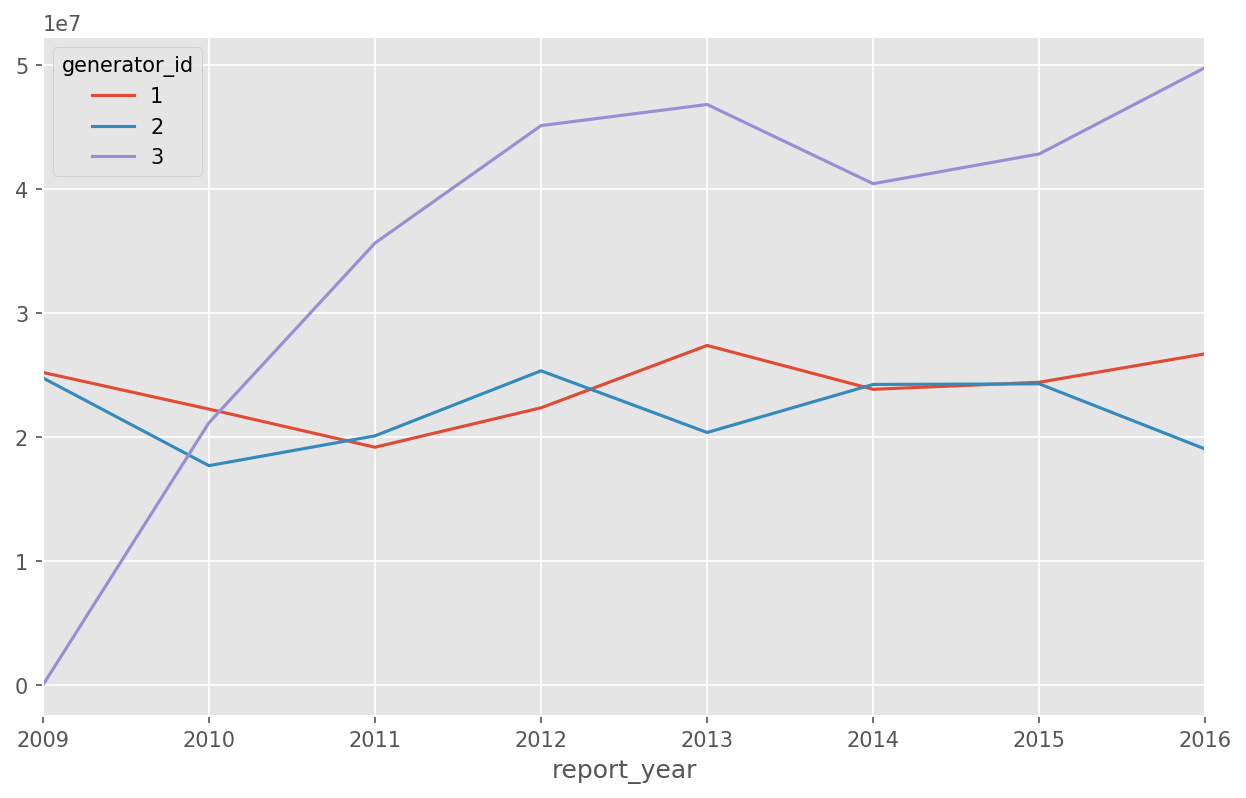

In [41]:
test_plant = 470
test_gens = ['1','2','3']
mmbtu = hr_good[(hr_good.plant_id_eia==test_plant) &
                (hr_good.generator_id.isin(test_gens))].\
    pivot(index='report_year',
          values='fuel_consumed_mmbtu_generator',
          columns='generator_id')
print(mmbtu)
mmbtu.plot();

generator_id          1          2          3
report_year                                  
2009          2345954.0  2359065.0        0.0
2010          2079261.0  1698091.0  2262083.0
2011          1797526.0  1905219.0  3791791.0
2012          2075543.0  2360188.0  4686054.0
2013          2226997.0  1911678.0  4820984.0
2014          1924289.0  2303340.0  4062154.0
2015          2011914.0  2286903.0  4337199.0
2016          2138679.0  1836695.0  5084336.0


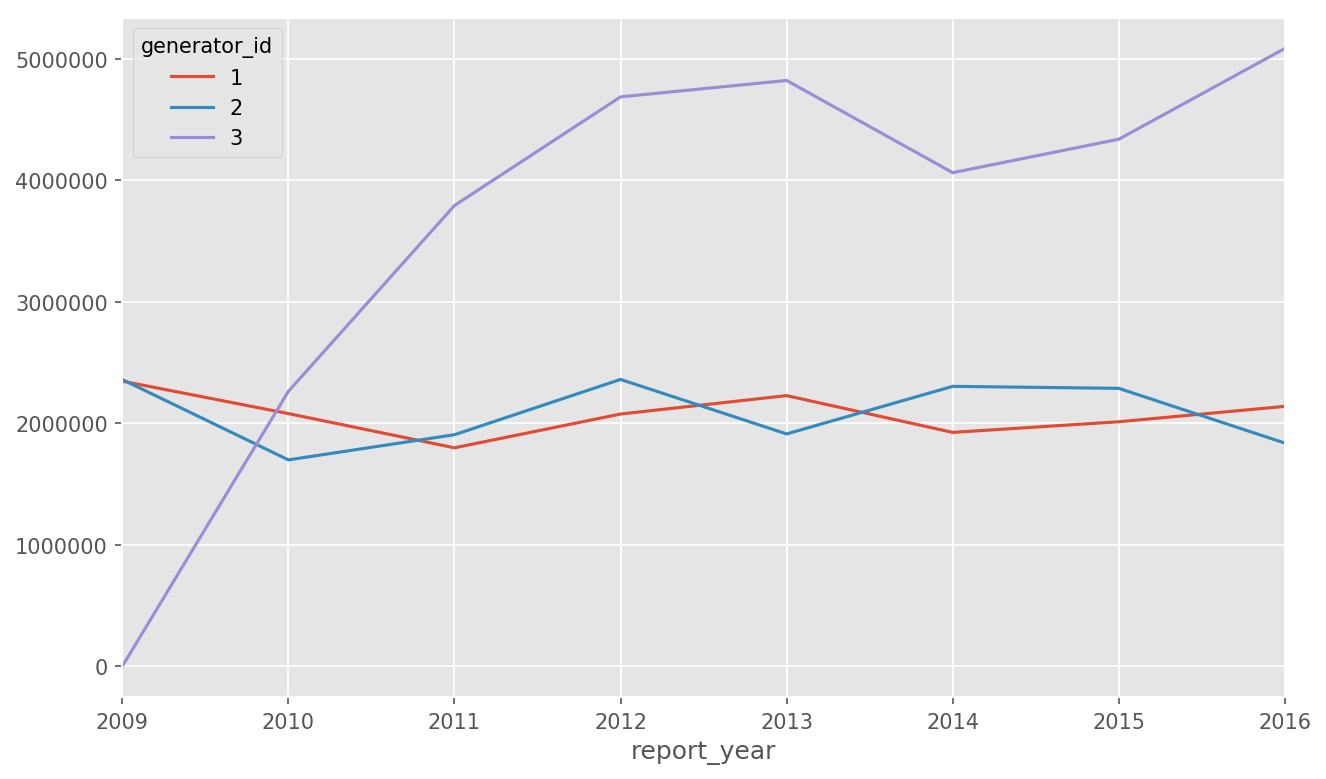

In [42]:
netgen = hr_good[(hr_good.plant_id_eia==test_plant) &
                 (hr_good.generator_id.isin(test_gens))].\
    pivot(index='report_year',
          values='net_generation_mwh',
          columns='generator_id')
print(netgen)
netgen.plot();

generator_id          1          2         3
report_year                                 
2009          10.752910  10.505438       NaN
2010          10.708973  10.425777  9.354442
2011          10.676170  10.554579  9.403469
2012          10.778972  10.742674  9.630197
2013          12.302649  10.660480  9.714219
2014          12.399931  10.530235  9.956092
2015          12.142245  10.625666  9.877866
2016          12.497895  10.366244  9.797993


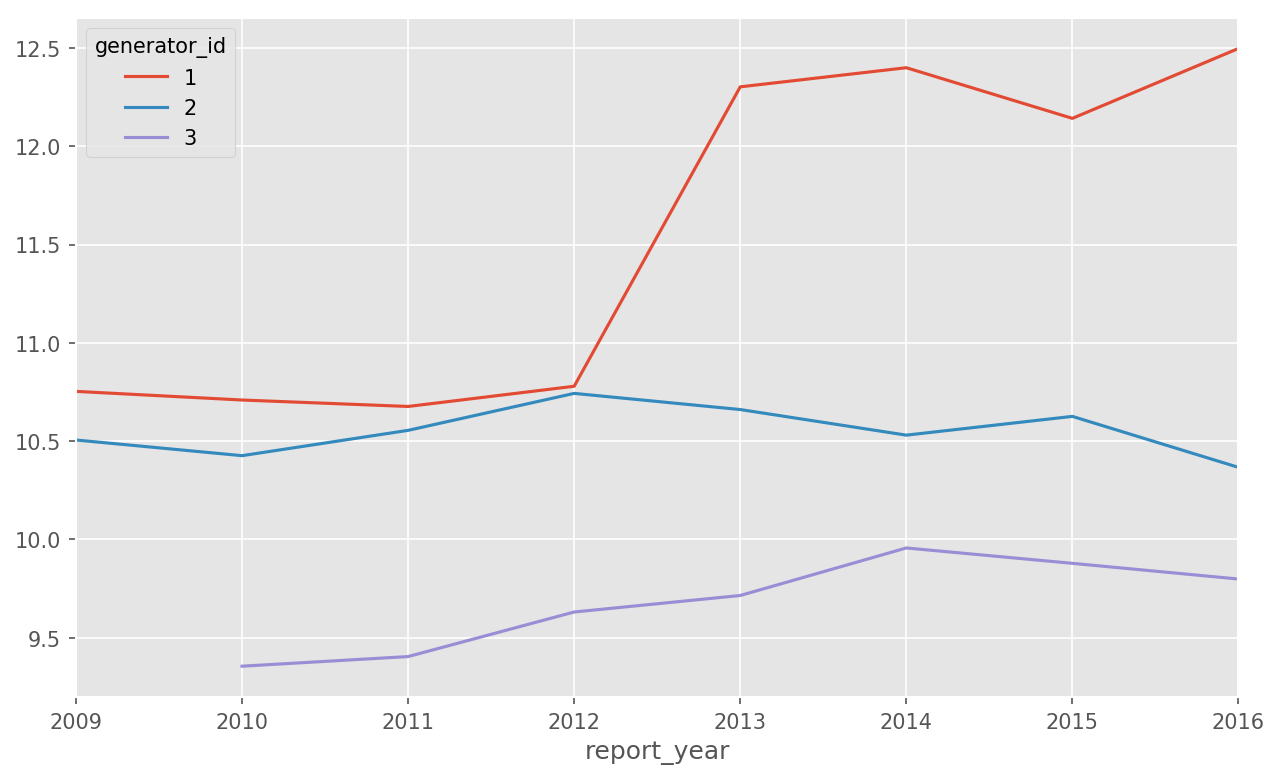

In [43]:
hr = hr_good[(hr_good.plant_id_eia==test_plant) &
             (hr_good.generator_id.isin(test_gens))].\
    pivot(index='report_year',
          values='heat_rate_mmbtu_mwh',
          columns='generator_id')
print(hr)
hr.plot();

### Heat Rate

In [52]:
heat_rate = mcoe.heat_rate(g8_es, bga8, g9_summed, bf9_summed, bf9_plant_summed, pudl_engine, plant_id='plant_id_eia')

In [56]:
heat_rate.sample(10)

,boiler_generator_assn,boiler_id,complete_assn,fuel_consumed_mmbtu_generator,generator_id,heat_rate_mmbtu_mwh,heatrate_calc,net_generation_mwh,plant_assn,plant_id_eia,plant_id_pudl,report_year
25778,False,NaN,False,NaN,CT12,7.330340,dissociated_fix,955248.0,False,55173,10,2016
15107,NaN,NaN,True,8.236147e+06,GEN6,25.440937,associated_good,323736.0,True,10864,3455,2014
7072,NaN,NaN,True,3.489260e+07,2,8.936598,associated_good,3904461.0,True,2712,515,2010
12329,True,U2,False,NaN,2,10.647070,dissociated_fix,151927.0,True,988,577,2013
22092,NaN,NaN,True,4.276767e+05,ST1,50.137953,associated_good,8530.0,True,57075,5501,2015
2124,NaN,NaN,True,1.652380e+06,1,12.071299,associated_good,136885.0,True,708,243,2014
23298,True,CBYB41,False,NaN,4,7.750514,dissociated_fix,431434.0,False,56806,5298,2015
15951,NaN,NaN,True,1.369737e+06,GEN1,15.488108,associated_good,88438.0,True,50277,3596,2011
8393,NaN,NaN,True,0.000000e+00,3,NaN,associated_good,0.0,True,3152,2289,2014
2068,False,NaN,False,NaN,GEN2,11.803815,unassociated_good,29387.0,False,50061,3493,2015


In [54]:
fuel_cost = mcoe.fuel_cost(g8_es, g9_summed, frc9_summed, frc9_summed_plant, heat_rate)

In [57]:
plt.hist(fuel_cost.sample(10)

,energy_source,energy_source_cons,energy_source_count,fuel_cost_es,fuel_cost_per_mmbtu_es,fuel_cost_per_mmbtu_plant,fuel_cost_per_mwh,fuel_cost_plant,generator_id,heat_rate_mmbtu_mwh,mmbtu_es,mmbtu_plant,nameplate_capacity_mw,net_generation_mwh,operator_name,plant_id_eia,plant_id_pudl,plant_name,report_year,state
5174,BIT,coal,1.0,NaN,NaN,4.046932,50.722654,1.527857e+07,2,12.533607,NaN,3.775346e+06,150.0,160455.00,Duke Energy Indiana Inc,1008,205,R Gallagher,2012,IN
9686,BLQ,biomass_solid,1.0,NaN,NaN,NaN,NaN,NaN,GN12,25.478187,NaN,3.717729e+06,46.0,253126.00,RockTenn-West Point Mill,10017,3091,West Point Mill,2014,VA
8309,LIG,coal,1.0,NaN,NaN,NaN,NaN,NaN,RHGF,11.361369,NaN,3.333921e+07,513.7,2928284.00,"Choctaw Generation L.P, L.L.L.P.",55076,4398,Red Hills Generating Facility,2013,MS
1526,BIT,coal,1.0,NaN,NaN,NaN,NaN,NaN,TG3,53.591991,NaN,NaN,28.0,50900.00,University of North Carolina,54276,4057,Univ of NC Chapel Hill Cogen Facility,2009,NC
5066,NG,gas,1.0,NaN,NaN,NaN,NaN,NaN,3,16.477782,NaN,NaN,23.5,3855.00,City of Colorado Springs - (CO),493,1498,George Birdsall,2012,CO
11589,NG,gas,1.0,NaN,NaN,NaN,NaN,NaN,MV4B,7.651919,NaN,4.400167e+07,164.6,907030.51,Southern California Edison Co,358,397,Mountainview Generating Station,2015,CA
4895,NG,gas,1.0,NaN,NaN,4.198170,31.832347,4.180584e+07,STG2,7.582434,NaN,9.958110e+06,122.0,439453.00,Entergy Louisiana Inc,55467,436,Ouachita,2011,LA
15161,SUB,coal,1.0,NaN,NaN,1.095831,11.129213,1.368883e+08,3,10.155959,NaN,1.249174e+08,570.0,3947992.00,Basin Electric Power Coop,6204,2580,Laramie River Station,2016,WY
9052,BIT,coal,1.0,NaN,NaN,NaN,NaN,NaN,1,11.078013,NaN,1.226725e+07,155.3,408768.00,"Cayuga Operating Company, LLC",2535,2100,Cayuga Operating Company,2014,NY
15038,BIT,coal,1.0,NaN,NaN,2.368042,24.243817,2.970332e+08,2,10.237918,NaN,1.254341e+08,684.0,3414607.00,Allegheny Energy Supply Co LLC,3944,250,FirstEnergy Harrison Power Station,2016,WV


In [ ]:
plt.hist(heat_rate.heat_rate_mmbtu_mwh,
         bins=100,range=(0,30),
         alpha=0.5,
         color='black',
         label="coal",
         weights=heat_rate.net_generation_mwh)
plt.title("Heat Rate")
plt.legend();

### Fuel Cost Calc

/Users/zaneselvans/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/zaneselvans/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


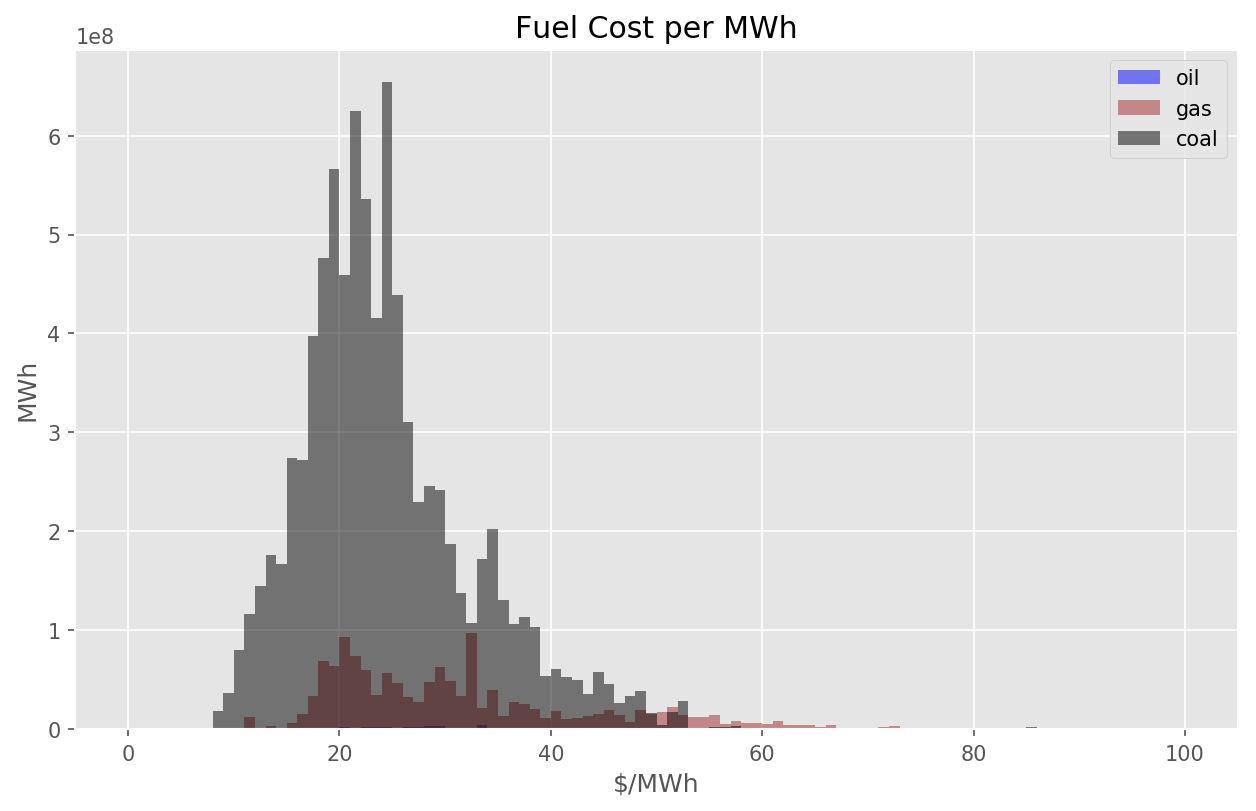

In [58]:
#plt.hist(mmbtu_one_fuel_bit.mmbtu_propotion_es, range=(.4,1), bins=100, alpha=0.5, color='green', label="BIT")
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'oil'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='blue', label="oil",weights=fuel_cost[fuel_cost['energy_source_cons'] == 'oil'].net_generation_mwh)
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'gas'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='brown', label="gas", weights=fuel_cost[fuel_cost['energy_source_cons'] == 'gas'].net_generation_mwh)
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'coal'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='black', label="coal",weights=fuel_cost[fuel_cost['energy_source_cons'] == 'coal'].net_generation_mwh)
plt.xlabel("$/MWh")
plt.ylabel("MWh")
plt.title("Fuel Cost per MWh")
plt.legend();

## Guts....

Prepping for simplifying fuel cost function

In [ ]:
# for use in simplifying the fuel cost funciton
plant_types = {'one_fuel': (g8_es[g8_es['energy_source_count'] == 1], frc9_summed_plant),
               'multi_fuel': (g8_es[g8_es['energy_source_count'] > 1], frc9_summed)}

In [ ]:
plant_types['multi_fuel'][1]

In [ ]:
for plants in plant_types:
    print(plants)

### Creation of the fuel cost calc

In [ ]:
one_fuel_plants = g8_es[g8_es['energy_source_count'] == 1]

In [ ]:
multi_fuel_plants = g8_es[g8_es['energy_source_count'] > 1]

OhMiGosh Actually calculating Fuel Cost

In [ ]:
# Multi Fuel Method

In [ ]:
net_gen_multi_fuel = g9_summed.merge(multi_fuel_plants, how='left', on=[
                          'plant_id_eia', 'generator_id','report_year'])
net_gen_multi_fuel.dropna(inplace=True)

# Merge this net_gen table with frc9_summed to have
# fuel_cost_per_mmbtu_total associated with generators
fuel_cost_per_mmbtu_multi_fuel = net_gen_multi_fuel.merge(frc9_summed,
                                    how='left',
                                    on=['plant_id_eia',
                                        'report_year',
                                        'energy_source_cons'])

fuel_cost_multi_fuel = fuel_cost_per_mmbtu_multi_fuel.merge(heat_rate[['plant_id_eia',
                                                 'report_year',
                                                 'generator_id',
                                                 'net_generation_mwh',
                                                 'heat_rate_mmbtu_mwh']],
                                      on=['plant_id_eia',
                                          'report_year',
                                          'generator_id',
                                          'net_generation_mwh'])

# Calculate fuel cost per mwh using average fuel cost given year, plant,
# fuel type; divide by generator-specific heat rate
fuel_cost_multi_fuel['fuel_cost_per_mwh'] = (fuel_cost_multi_fuel['fuel_cost_per_mmbtu_average'] * fuel_cost_multi_fuel['heat_rate_mmbtu_mwh'])

In [ ]:
fuel_cost_multi_fuel[fuel_cost_multi_fuel.fuel_cost_per_mwh.isnull()].count()

In [ ]:
# One Fuel Method

In [ ]:
net_gen_one_fuel = g9_summed.merge(one_fuel_plants, how='left', on=[
                          'plant_id_eia', 'generator_id','report_year'])
net_gen_one_fuel.dropna(inplace=True)

# Merge this net_gen table with frc9_summed_plant to have
# fuel_cost_per_mmbtu_total associated with generators
fuel_cost_per_mmbtu_one_fuel = net_gen_one_fuel.merge(frc9_summed_plant,
                                   how='left',
                                    on=['plant_id_eia',
                                        'report_year'])

fuel_cost_one_fuel = fuel_cost_per_mmbtu_one_fuel.merge(heat_rate[['plant_id_eia',
                                                 'report_year',
                                                 'generator_id',
                                                 'net_generation_mwh',
                                                 'heat_rate_mmbtu_mwh']],
                                      on=['plant_id_eia',
                                          'report_year',
                                          'generator_id',
                                         'net_generation_mwh'])

# Calculate fuel cost per mwh using average fuel cost given year, plant,
# fuel type; divide by generator-specific heat rate
fuel_cost_one_fuel['fuel_cost_per_mwh'] = (fuel_cost_one_fuel['fuel_cost_per_mmbtu_average']
                                  * fuel_cost_one_fuel['heat_rate_mmbtu_mwh'])

In [ ]:
# Squish them together!
fuel_cost = fuel_cost_one_fuel.append(fuel_cost_multi_fuel)

In [ ]:
fuel_cost_coal = fuel_cost[fuel_cost['energy_source_cons'] == 'coal']
fuel_cost_coal.describe()

In [ ]:
fuel_cost_gas = fuel_cost[fuel_cost['energy_source_cons'] == 'gas']
fuel_cost_gas.describe()

In [ ]:
fuel_cost_gas.net_generation_mwh.sum()

In [ ]:
fuel_cost_coal.describe()

In [ ]:
#plt.hist(mmbtu_one_fuel_bit.mmbtu_propotion_es, range=(.4,1), bins=100, alpha=0.5, color='green', label="BIT")
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'oil'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='blue', label="oil",weights=fuel_cost[fuel_cost['energy_source_cons'] == 'oil'].net_generation_mwh)
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'gas'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='brown', label="gas", weights=fuel_cost[fuel_cost['energy_source_cons'] == 'gas'].net_generation_mwh)
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'coal'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='black', label="coal",weights=fuel_cost[fuel_cost['energy_source_cons'] == 'coal'].net_generation_mwh)
plt.xlabel("$/MWh")
plt.ylabel("MWh")
plt.title("Fuel Cost per MWh")
plt.legend();

In [ ]:
fuel_cost_gas[fuel_cost_gas.fuel_cost.isnull()]

### Exploration of missing fuel costs.

In [ ]:
# The frc9 pull is being done in a formula now from outputs and is thus not needed for calculating heat rate
# But it's useful for checking missing fuel costs from the original frc table
frc9 = analysis.simple_select_with_pudl_plant_id('fuel_receipts_costs_eia923', pudl_engine)
frc9['fuel_cost'] = (frc9['fuel_quantity'] * frc9['average_heat_content'] * frc9['fuel_cost_per_mmbtu'])
frc9['mmbtu'] =  (frc9['fuel_quantity'] * frc9['average_heat_content'])

frc9['energy_source_cons'] = frc9.energy_source.copy()

for energy_source_cons in constants.energy_source_map.keys():
    for energy_source in constants.energy_source_map[energy_source_cons]:
        frc9.loc[frc9.energy_source==energy_source, 'energy_source_cons'] = energy_source_cons 

In [ ]:
# Are we missing data from frc, or is there not cost info?
missing_in_frc = fuel_cost_one_fuel[fuel_cost_one_fuel.fuel_cost.isnull()]
missing_in_frc = missing_in_frc[['plant_id_eia','report_year']].drop_duplicates()
frc9['report_year'] = pd.to_datetime(frc9.report_date).dt.year
missing = missing_in_frc.merge(frc9,left_on=['plant_id_eia','report_year'],right_on=['plant_id_eia','report_year'])
missing[~missing.fuel_cost_per_mmbtu.isnull()]
# It apears that there are no missing frc records that actually have a fuel cost record. 

### Exploration into portion of naturual gas for startup fuel from coal plants

In [ ]:
frc9_summed = frc9_summed.rename(columns={'energy_source':'energy_source_fuel'})
one_fuel_plants = one_fuel_plants.rename(columns={'energy_source':'energy_source_plant'})

frc9_summed = frc9_summed.rename(columns={'energy_source_cons':'energy_source_cons_fuel'})
one_fuel_plants = one_fuel_plants.rename(columns={'energy_source_cons':'energy_source_cons_plant'})

In [ ]:
mmbtu_one_fuel_es = frc9_summed.merge(one_fuel_plants.drop_duplicates(subset=['plant_id_eia','energy_source_plant','report_year']),
                                    how='left',
                                    on=['plant_id_eia',
                                        'report_year'])
# we'll merge with a total plant mmbtu, so we need to rename the per energy_source mmtbu
# we also need to drop all the NaN columns bc they are the multi fuel plants
# we also only need a few columns
mmbtu_one_fuel_es = mmbtu_one_fuel_es.rename(columns={'mmbtu': 'mmbtu_es'})\
                                     .dropna()\
                                     .drop(['fuel_cost',
                                            'fuel_cost_per_mmbtu_average',
                                            'generator_id',
                                            'energy_source_count'],axis=1)

In [ ]:
mmbtu_one_fuel_plant = frc9_summed_plant.merge(one_fuel_plants.drop_duplicates(subset=['plant_id_eia','energy_source_plant','report_year']),
                                    how='left',
                                    on=['plant_id_eia',
                                        'report_year'])
mmbtu_one_fuel_plant = mmbtu_one_fuel_plant.rename(columns={'mmbtu': 'mmbtu_plant'})\
                                           .dropna()\
                                           .drop(['fuel_cost',
                                                  'fuel_cost_per_mmbtu_average',
                                                  'generator_id',
                                                  'energy_source_count'],axis=1)

In [ ]:
mmbtu_one_fuel = mmbtu_one_fuel_es.merge(mmbtu_one_fuel_plant,how='left',on=['plant_id_eia','report_year','energy_source_plant','energy_source_cons_plant'])


In [ ]:
mmbtu_one_fuel['mmbtu_propotion_es'] = mmbtu_one_fuel['mmbtu_es']/mmbtu_one_fuel['mmbtu_plant']

In [ ]:
mmbtu_one_fuel[mmbtu_one_fuel['energy_source_cons_fuel'] == 'coal'].count()

In [ ]:
mmbtu_one_fuel_coal = mmbtu_one_fuel[(mmbtu_one_fuel['energy_source_cons_plant'] == 'coal') & 
                                    (mmbtu_one_fuel['energy_source_cons_fuel'] == 'coal')]

In [ ]:
mmbtu_one_fuel_coal[mmbtu_one_fuel_coal['mmbtu_propotion_es'] < .8].drop_duplicates(subset=['plant_id_eia'])

In [ ]:
mmbtu_one_fuel_coal.describe()

In [ ]:
plt.hist(mmbtu_one_fuel_coal.mmbtu_propotion_es, range=(.9,1), bins=100, alpha=0.5, color='black', label="coal")
plt.xlabel("Proportion")
plt.ylabel("Number of records")
plt.title("Proportion of Coal Receipts")
plt.legend();

Additional problem exploration...

In [ ]:
# There are some generators out of 27,000 that don't have records in the generators table
# A chunk of these appear to be plants that are retired mid-way through a year
# this will be fixed when we pull in the retired tab into the generators table.
# A chunk of these appear to be genertors added after 2016. This should be fiexed
# when we pull in 2016 data.
test = g9_summed.merge(net_gen_one_fuel.append(net_gen_multi_fuel),how='left')
test[test.energy_source.isnull()].count()